# 睿抗 2025 智海人工智能算法应用赛
**语音情绪识别**：官网基线代码  
跑完官方基线：线上测试分数 约 0.677

# 音频情绪分析

## 1. 赛项背景

### 1.1 引言和背景介绍：
  音频情绪分析是一项涉及音频信号处理和情感识别的任务，旨在从音频数据中自动识别和分析情感状态。随着音频数据的快速增长和情感智能识别的应用需求增加，音频情绪分析成为了一个备受关注的研究领域。通过对音频信号的分析和建模，我们可以深入了解音频中的情感表达和语义信息，为实现情感驱动的应用和音频内容的智能推荐提供重要支持。  
  在音频情绪分析领域，已有大量的研究工作和技术方法。从传统的基于信号处理和机器学习的方法到现代的基于深度学习的方法，研究者们不断探索和改进情感识别的技术手段。传统方法主要依赖于手工设计的特征提取和分类器，而深度学习方法通过端到端的学习从原始音频数据中学习特征表示和情感分类模型。然而，音频情绪分析仍面临着诸多挑战，如音频数据的多样性、情感表达的主观性和多样性、数据标注的困难等。

### 1.2 项目目标和意义：
   本赛题旨在利用音频情绪分析技术，开发一个高效准确的语音情绪分类模型，为实际应用中的情感驱动系统和情感智能识别提供可靠的解决方案。  
   通过该赛题能够改进情感识别的准确性和鲁棒性，探索新的特征表示和模型结构，以满足不同应用场景对音频情绪分析的需求。这将有助于实现更加智能和个性化的客户服务、音乐推荐和情感监测等应用。

## 2. 数据集介绍

数据集包含多语种的音频文件，涵盖了 5 种情感类别的音频样本，包括 anger、fear、happy、neutral、sad，文件类型均为 `wav` 格式。  
音频文件统一处理为 44100 Hz，进行单位范数归一化处理，防止音量过大或过小，并采用简易降噪。  
数据集路径为 `datasets/67fc7ccbb88b01da6626732d-momodel/train`

数据集结构  
``` 
train
├── anger/  
│   ├── 1.wav  
│   ├── 2.wav  
│   ├── ...   
├── fear/
│   ├── 1.wav
│   ├── 2.wav
│   ├── ... 
├── happy/
│   ├── 1.wav
│   ├── 2.wav
│   ├── ... 
├── netural/
│   ├── 1.wav
│   ├── 2.wav
│   ├── ... 
└── sad/
    ├── 1.wav
    ├── 2.wav
    ├── ... ``` 

`PyTorch`是一个开源的深度学习框架，具有以下特点和优势：

- 强大的计算能力：`PyTorch` 提供了高效的张量计算和自动求导功能，可以处理大规模的音频数据集和复杂的神经网络模型。
- 灵活的模型构建：`PyTorch` 采用了动态图的编程模式，可以根据需要灵活选择使用动态图进行快速原型设计和调试。
- 易于使用的接口：`PyTorch` 提供了简洁、直观的API和模型组件，使模型构建、训练和评估过程更加简单和可控。

下面使用 `PyTorch` 搭建模型，并逐步实现音频情绪分类任务。  
主要流程包括数据预处理、特征提取、模型构建和训练、性能评估等。

## 3. 数据处理

### 3.1 处理步骤:

1. 提取音频特征，包括 MFCC 特征、谱质心和谱带宽特征 : 


- MFCC 能够反映音频信号的谐波结构和频谱包络，还能够能够捕捉音频信号的频率分布，包括基频和谐波成分;
- 谱带宽指信号的频谱分布的宽度，可以用来反映音频信号在频率轴上的波动程度或频谱的宽窄程度；
- 谱质心指信号的频谱分布在频率轴上的中心位置，可以用来反映音频的音调或音色特征。它代表了频谱分布的平均频率，可以用来描述音频信号的整体音高。


2. 将特征在特征维度进行标准化，利用零填充的方式对各特征处理，使其维度同一为 300。


- 不同特征往往具有不同的度量单位，这导致特征值的范围差异很大。标准化可以消除这些差异，使得不同特征具有相同的尺度，有利于模型的收敛和优化过程。



3. 将处理后的特征进行合并，不同类型的特征融合在一起，综合利用多个信息源的信息，以更全面地表达音频中的情绪信息。

In [1]:
import torch
import random
import numpy as np

In [2]:
def set_seed(seed=42):
    random.seed(seed)  # Python 内置随机数
    np.random.seed(seed)  # NumPy 随机数
    torch.manual_seed(seed)  # CPU 上的随机数
    torch.cuda.manual_seed(seed)  # GPU 上的随机数
    torch.cuda.manual_seed_all(seed)  # 多 GPU 情况下的随机数
    torch.backends.cudnn.deterministic = True  # 确保每次卷积结果一致
    torch.backends.cudnn.benchmark = False     # 禁用自动优化

set_seed()

In [3]:
import torchaudio.transforms as T
import torchaudio

In [4]:
def compute_feature(audio, sample_rate = 44100, n_fft = 2048, win_length = 2048, hop_length = 512, p = 2):
    # 计算音频的谱质心和 谱带宽
    window = torch.hann_window(win_length)

    stft = torch.stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window = window, return_complex=True)
    magnitude = stft.abs().squeeze(0) # [freq_bins, time_frames]
    # 计算频率 bin 对应的频率
    freq_bins = magnitude.size(0)
    freqs = torch.linspace(0, sample_rate / 2, steps=freq_bins).unsqueeze(1)  # [freq_bins, 1]
    # 计算谱质心
    centroid = (freqs * magnitude).sum(dim=0) / (magnitude.sum(dim=0) + 1e-10)  # [time_frames]
    # 计算谱带宽
    deviation = (freqs - centroid.unsqueeze(0)).abs() ** p
    bandwidth = (magnitude * deviation).sum(dim=0) / (magnitude.sum(dim=0) + 1e-10)
    bandwidth = bandwidth ** (1 / p)  # [time_frames]

    return centroid.unsqueeze(0), bandwidth.unsqueeze(0)

In [5]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T
import numpy as np

class AudioEmotionDataset(Dataset):
    def __init__(self, root_dir, n_mfcc=10, max_len=300, sr=44100, n_fft=2048, hop_length=512, win_length=2048, p=2):
        self.root_dir = root_dir
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.p = p

        self.data = []
        self.labels = []
        self.label2idx = {}

        self._load_dataset()
        self.file_list = self.data  # ✅ 添加用于外部分层抽样

    def _load_dataset(self):
        label_names = sorted(os.listdir(self.root_dir))
        self.label2idx = {label: idx for idx, label in enumerate(label_names)}

        for label in label_names:
            label_path = os.path.join(self.root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.endswith(".wav"):
                    file_path = os.path.join(label_path, fname)
                    self.data.append(file_path)
                    self.labels.append(self.label2idx[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]

        audio, sr = torchaudio.load(file_path)

        # 重采样
        resampler = T.Resample(orig_freq=sr, new_freq=self.sr)
        audio = resampler(audio).float()

        # === MFCC ===
        mfcc_transform = T.MFCC(
            sample_rate=self.sr,
            n_mfcc=self.n_mfcc,
            melkwargs={'n_fft': self.n_fft, 'hop_length': self.hop_length}
        )
        mfcc = mfcc_transform(audio)  # shape: [1, n_mfcc, T]

        # === 自定义谱特征 ===
        centroid, bandwidth = compute_feature(
            audio,
            sample_rate=self.sr,
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            p=self.p
        )

        # 合并特征
        feature = torch.cat([mfcc.squeeze(0), centroid, bandwidth], dim=0)

        # 标准化
        feature = (feature - feature.mean(dim=1, keepdim=True)) / (feature.std(dim=1, keepdim=True) + 1e-6)

        # 填充或裁剪
        if feature.shape[1] < self.max_len:
            pad_width = self.max_len - feature.shape[1]
            feature = torch.nn.functional.pad(feature, (0, pad_width), mode='constant', value=0)
        else:
            feature = feature[:, :self.max_len]

        # 转为 [T, feature_dim]
        feature = feature.transpose(0, 1)

        return feature, torch.tensor(label, dtype=torch.long)


下列代码创建 dataloader 实例

可视化某个音频文件中提取的特征曲线

In [6]:
# import matplotlib.pyplot as plt

# for x, y in train_loader:
#     plt.figure(figsize=(10, 6))
#     sample = x[0, : ,:].T
#     for i in range(sample.shape[0]):
#         plt.plot(sample[i], label=f"con_feature {i+1}")
#     plt.xlabel("Time")
#     plt.ylabel("feature")
#     plt.legend(loc="upper right")
#     plt.title("feature")
#     plt.show()
#     break

- 特征融合使特征表达更全面：MFCC 主要反映音色与语音内容，谱质心描述频谱能量集中程度，谱带宽则衡量频率分布范围。融合后能提供更完整、立体的音频描述。  
- 不同特征对噪声的敏感性不同，融合后可以互相补充、弱化噪声影响，增强模型对复杂背景环境的适应能力。  
- 多维度特征融合为模型提供更多判别信息，提升模型对情绪、说话人或环境类型的识别效果。  
- 单一特征在某些场景下可能失效，而多特征融合能在不同场景中保持稳定表现，减少模型对特定特征的依赖。  



## 4. 模型构建

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class SERModel(nn.Module):
    def __init__(self, input_dim=12, num_classes=5, cnn_out_channels=64, lstm_hidden=128, lstm_layers=2):
        super(SERModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_out_channels, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))  # (T/2, F/2)
        )

        # BiLSTM to capture temporal dependencies
        self.bilstm = nn.LSTM(
            input_size=(input_dim // 2) * cnn_out_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Linear(2 * lstm_hidden, 1)

        # Final classifier
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (B, T, F) => (B, 1, T, F)
        x = x.unsqueeze(1)
        x = self.cnn(x)  # (B, C, T', F')
        B, C, T, F = x.size()
        x = x.permute(0, 2, 1, 3).contiguous().view(B, T, C * F)  # (B, T, C*F)

        x, _ = self.bilstm(x)  # (B, T, 2*H)
        attn_weights = torch.softmax(self.attention(x), dim=1)  # (B, T, 1)
        x = torch.sum(attn_weights * x, dim=1)  # (B, 2*H) 根据注意力权重计算加权值
        out = self.fc(x)
        return out

## 5. 模型训练

使用`Adam`优化器对网络模型的可训练参数进行优化，并使用`CrossEntropyLoss`交叉熵损失函数计算模型的损失。  

``` python
batch_size = 32  
lr = 0.001   
```

将训练得到的的模型储存到`result/`路径下。  
notebook 环境只能使用 cpu 进行训练，因此将训练代码转为 .py 格式，并在 gpu 环境中训练，具体可参照 `train.py` 文件。





In [9]:
import os
import librosa
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

data_path = 'datasets/67fc7ccbb88b01da6626732d-momodel/train/'

emotion_counts = Counter()
durations_per_class = defaultdict(list)
all_durations = []
all_labels = []

# 遍历每个类别文件夹
for emotion in os.listdir(data_path):
    emotion_dir = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    wav_files = [f for f in os.listdir(emotion_dir) if f.endswith('.wav')]
    emotion_counts[emotion] += len(wav_files)

    for wav_file in wav_files:
        file_path = os.path.join(emotion_dir, wav_file)
        try:
            y, sr = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations_per_class[emotion].append(duration)
            all_durations.append(duration)
            all_labels.append(emotion)
        except Exception as e:
            print(f"读取失败: {file_path}，原因: {e}")

# === 打印统计信息 ===
print("📊 类别数量统计：")
for emotion, count in emotion_counts.items():
    print(f"  {emotion:>7} : {count} 个样本")

print("\n🎧 音频时长统计：")
print(f"  平均时长: {sum(all_durations)/len(all_durations):.2f} 秒")
print(f"  最短时长: {min(all_durations):.2f} 秒")
print(f"  最长时长: {max(all_durations):.2f} 秒")

# 每类平均时长
print("\n📈 每个类别的平均时长：")
for emotion, durations in durations_per_class.items():
    avg_dur = sum(durations) / len(durations)
    print(f"  {emotion:>7} : {avg_dur:.2f} 秒")

📊 类别数量统计：
    anger : 1642 个样本
     fear : 1350 个样本
    happy : 1622 个样本
  neutral : 1467 个样本
      sad : 1675 个样本

🎧 音频时长统计：
  平均时长: 2.67 秒
  最短时长: 1.25 秒
  最长时长: 7.13 秒

📈 每个类别的平均时长：
    anger : 2.71 秒
     fear : 2.47 秒
    happy : 2.58 秒
  neutral : 2.64 秒
      sad : 2.88 秒


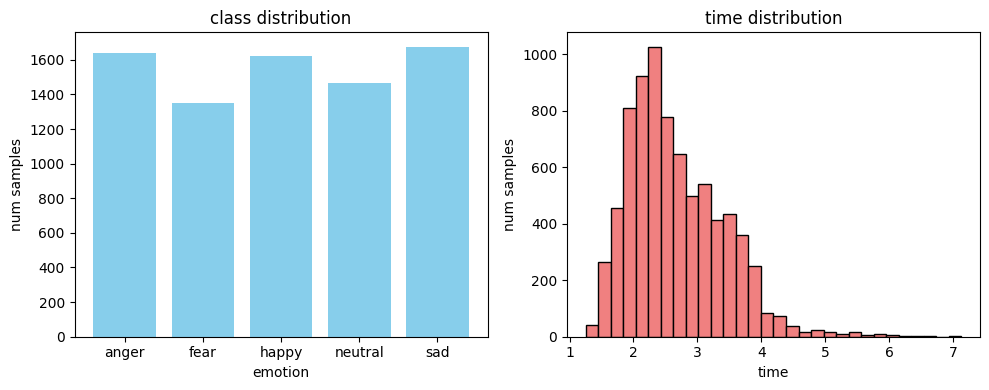

In [10]:
# === 可视化 ===
plt.figure(figsize=(10, 4))

# 类别分布条形图
plt.subplot(1, 2, 1)
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.title("class distribution")
plt.xlabel("emotion")
plt.ylabel("num samples")

# 时长分布直方图
plt.subplot(1, 2, 2)
plt.hist(all_durations, bins=30, color='lightcoral', edgecolor='black')
plt.title("time distribution")
plt.xlabel("time")
plt.ylabel("num samples")

plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

data_path = 'datasets/67fc7ccbb88b01da6626732d-momodel/train/'
dataset = AudioEmotionDataset(data_path)

all_indices = list(range(len(dataset)))
all_labels = dataset.labels  # ✔️ 可以直接用于 stratify

train_idx, val_idx = train_test_split(
    all_indices,
    test_size=0.2,
    stratify=all_labels,
    shuffle=True,
    random_state=42
)

train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False)

In [12]:
# 查看一个 batch 的数据形状
for batch in train_loader:
    features, labels = batch
    print(f"特征 shape: {features.shape}")  # 通常是 [B, T, D]
    print(f"标签 shape: {labels.shape}")    # 通常是 [B]
    break  # 只看第一个 batch 就行

特征 shape: torch.Size([32, 300, 12])
标签 shape: torch.Size([32])


In [13]:
# === 2. 模型、损失、优化器 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SERModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# 混合精度
scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')

# === 3. 训练循环 ===
num_epochs   = 30
best_val_f1  = 0.0
save_path    = "./results/best_model.pth"

for epoch in range(1, num_epochs + 1):
    # ---- 3.1 训练 ----
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(inputs)
            loss    = criterion(outputs, labels)

        # 反向传播-混合精度
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)   # 按样本数累加更准确
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average='micro')
    train_loss /= len(train_set)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")

    # ---- 3.2 验证 ----
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='micro')
    print(f"[Epoch {epoch}] Validation F1: {val_f1:.4f}")

    # ---- 3.3 保存最佳模型 ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print(f"  🔥 New best model saved (F1 = {best_val_f1:.4f})")

print(f"Training finished. Best Validation F1 = {best_val_f1:.4f}")

Epoch 1/30: 100%|██████████| 193/193 [00:28<00:00,  6.84it/s]


[Epoch 1] Train Loss: 1.5695 | Train F1: 0.2694


TypeError: autocast.__init__() missing 1 required positional argument: 'device_type'

## 6. 模型评估

对训练好的模型，可以测试其在数据集上的评分。  
本样例代码没有将数据集划分为训练集与验证集，因此测试所得分数不能准确体现模型的性能。  
同学们可以将数据集进行划分以实现更准确的性能评估。  


In [ ]:
import torch
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel().to(device)
model.load_state_dict(torch.load("./results/best_model.pth", map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算评估指标
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='micro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

## 7. 评分

**注意：**

通过对以上步骤流程的了解，相信大家对该任务有了深刻的认识，但是模型比较简单，各超参数也没有调试      
评分指标也不高，大家可以试着写自己的模型，并将其调到最佳状态。   

1. 你可以在我们准好的接口中实现模型（若使用可以修改函数接口），也可以自己实现深度学习模型，写好代码后可以在 Py 文件中使用 GPU 进行模型训练。
2. 在训练模型等过程中如果需要**保存数据、模型**等请写到 **results** 文件夹，如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请务必将模型保存在 **results** 文件夹下。
3. 训练出自己最好的模型后，先按照下列 cell 操作方式实现 NoteBook 加载模型测试；请测试通过再进行【系统测试】。
4. 请填写你的模型路径及名称并补充 `predict()` 函数以实现预测。
5. 点击左侧栏提交结果后点击生成文件则需勾选 `predict()` 函数的 cell。
6. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
7. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
8. 测试提交时服务端会调用 `predict()` 函数，请不要修改该函数的输入输出及其数据类型。
9. 最终评分为 F1-score 指标。

===============  **模型预测代码答题区域**  =============  
在下方的代码块中编写 **模型预测 predict()** 部分的代码，请勿在别的位置作答。  
提交文件 `main.py` 中需要包含 `predict()` 函数，提交文件样例参考 `main.py`

In [ ]:
# -------------------------- 请加载最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 my_model.m 模型，则 model_path = './results/my_model.m'
path = None

# 加载模型
model = None

def predict(audio, sr):
    """
    模型预测
    param：
        audio : np.ndarray，由 torchaudio.load 读取的音频数据数据。
        sr: int, 由 torchaudio.load 读取的音频采样率。
        读取样例 audio, sr = torchaudio.load('./datasets/67fc7ccbb88b01da6626732d-momodel/train/neutral/1111.wav')
    return：
        y_predict : str, 数据label。
    """

    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 获取输入的类别
    y_predict = None

    # -------------------------------------------------------------------------

    # 返回类别
    return y_predict


========================================  **测试提交函数示例**  =========================================== 

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as audiof
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel().to(device)
model.load_state_dict(torch.load("./results/best_model.pth", map_location=device))
model.eval()

label = ['anger', 'fear', 'happy', 'neutral', 'sad']

class config:
    sr = 44100
    n_mfcc = 10
    n_fft = 2048
    hop_length = 512
    win_length = 2048
    p = 2
    max_len = 300


mfcc_transform = T.MFCC(sample_rate=config.sr, n_mfcc=config.n_mfcc, melkwargs={'n_fft': config.n_fft, 'hop_length': config.hop_length})

def predict(audio, sr):
    # 1) 重采样
    resampler = T.Resample(orig_freq=sr, new_freq=config.sr)
    audio = resampler(audio).float()

    # 2) 特征：MFCC + centroid + bandwidth
    mfcc = mfcc_transform(audio)
    centroid, bandwidth = compute_feature(
        audio, sample_rate=config.sr,
        n_fft=config.n_fft, win_length=config.win_length,
        hop_length=config.hop_length, p=config.p
    )
    feature = torch.cat([mfcc.squeeze(0), centroid, bandwidth], dim=0)

    # 3) 标准化 & 补／裁长
    feature = (feature - feature.mean(dim=1, keepdim=True)) / (feature.std(dim=1, keepdim=True) + 1e-6)
    if feature.shape[1] < config.max_len:
        pad = config.max_len - feature.shape[1]
        feature = torch.nn.functional.pad(feature, (0, pad))
    else:
        feature = feature[:, :config.max_len]

    feature = feature.transpose(0, 1).unsqueeze(0)  # [1, T, F]

    # === 关键：把特征搬到同一 device ===
    feature = feature.to(device)

    # 4) 推理
    with torch.no_grad():
        logits = model(feature)
        pred   = torch.argmax(logits, dim=1).item()

    return label[pred]

In [ ]:
predict_x, sr = torchaudio.load('./datasets/67fc7ccbb88b01da6626732d-momodel/train/neutral/1111.wav')
predict(predict_x, sr)